# ProtoDUNE DP VD PMT Analysis Jupyter Notebook
Authored by Jacob A. Smith.

This notebook serves as the place where you can compare different LArSoft simulations. Those simulations live on the DUNE GPVMs at /pnfs/dune/persistent/users/smithja/ and the FHiCL files and scripts to run/process those simulations live at /dune/app/users/smithja/.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# for creating custom plot legends
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%matplotlib inline

In [5]:
num_pmts = 36
coated_pmts = np.array([2, 10, 15, 21, 26, 34]) # TPB-coated PMTs
foil_pmts = np.delete( np.arange( num_pmts), coated_pmts) # PEN foil PMTs
pmt_plane_ypos = -376.5

# variables set at LAtSoft simulation stage(s)
energies        =  np.array([0.2, 0.4, 0.6, 0.8, 1])               # units: GeV
init_ypos       =  np.array([300, 200, 100, 0, -100, -200, -300])  # units: cm
reflectivities  =  np.array([ 40, 60, 90])                         # units: % reflectivity from photon library

In [6]:
# Data files needed into pandas data frames.

# Note: As we add more files some of the
# files will be in multiple file_ids arrays.

# Note: We do not include '-100Y0' in the 
#       numpy arrays here or at any other 
#       point in this code when specifying
#       initial y-position since including 
#       a '-' in a variable name is invalid 
#       syntax for Python

# variable: energy
ref40_vEng_file_ids = np.array([
    'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt2GeVP0_muons',
    'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt4GeVP0_muons',
    'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt6GeVP0_muons',
    'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt8GeVP0_muons',
    'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
])

ref60_vEng_file_ids = np.array([
    'REF60_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt2GeVP0_muons',
    'REF60_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt4GeVP0_muons',
    'REF60_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt6GeVP0_muons',
    'REF60_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt8GeVP0_muons',
    'REF60_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
])

ref90_vEng_file_ids = np.array([
    'REF90_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt2GeVP0_muons',
    'REF90_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt4GeVP0_muons',
    'REF90_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt6GeVP0_muons',
    'REF90_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt8GeVP0_muons',
    'REF90_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
])

# variable: distance
ref40_eng1GeV_vDist_file_ids = np.array([
    'REF40_sim_-238X0_300Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
    'REF40_sim_-238X0_200Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
    'REF40_sim_-238X0_100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
    'REF40_sim_-238X0_0Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
    'REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
    'REF40_sim_-238X0_-200Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
    'REF40_sim_-238X0_-300Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons',
])

# variable: reflectivity
eng0pt2GeV_vRef_file_ids = np.array([
    ref40_vEng_file_ids[0],
    ref60_vEng_file_ids[0],
    ref90_vEng_file_ids[0]
])

eng0pt4GeV_vRef_file_ids = np.array([
    ref40_vEng_file_ids[1],
    ref60_vEng_file_ids[1],
    ref90_vEng_file_ids[1]
])

eng0pt6GeV_vRef_file_ids = np.array([
    ref40_vEng_file_ids[2],
    ref60_vEng_file_ids[2],
    ref90_vEng_file_ids[2]
])

eng0pt8GeV_vRef_file_ids = np.array([
    ref40_vEng_file_ids[3],
    ref60_vEng_file_ids[3],
    ref90_vEng_file_ids[3]
])

eng1GeV_vRef_file_ids = np.array([
    ref40_vEng_file_ids[4],
    ref60_vEng_file_ids[4],
    ref90_vEng_file_ids[4]
])

In [7]:
def lin_fit_func( x, m, b):
    return m*x + b

def exp_fit_func( x, a, r, b):
    return a * np.exp( x / r) + b

### Plot of Efficiency v. Energy

This data is taken from simulations with the following file structure:
'\<REFLECTIVITY\>\_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_\<ENERGY\>GeVP0_muons' 
where \<REFLECTIVITY\> and \<ENERGY\> are replaced with the appropriate formatted string version of such values.

We use the ratio of PMT 33 to PMT 34 because it is the closest PMT pair to the incident particle's initial position in our simulations. Since ionizing particles will lose energy as they go through the liquid argon and we are after a measure of efficiency as a function of energy, we consider the ratio of PMT 33 to PMT 34 to be the most insightful.

In [8]:
# 'refXX' specifies reflectivity percentage.
# '_vEng' specifies that these arrays will be used when plotting efficiency 
# against initial energy for the incident particle (with fixed planar distance,
# i.e. the incident particle's y-position is always set to -100 cm). This
# distinction is made since below we also look at efficiency as a function
# of initial particle y-distance to the PMT plane (with energy being held 
# constant).
ref40_mean_efficiencies_vEng = np.full( len( energies), -1.)
ref40_mean_eff_errors_vEng   = np.full( len( energies), -1.)
ref40_mode_efficiencies_vEng = np.full( len( energies), -1.)
ref40_mode_eff_errors_vEng   = np.full( len( energies), -1.)

ref60_mean_efficiencies_vEng = np.full( len( energies), -1.)
ref60_mean_eff_errors_vEng   = np.full( len( energies), -1.)
ref60_mode_efficiencies_vEng = np.full( len( energies), -1.)
ref60_mode_eff_errors_vEng   = np.full( len( energies), -1.)

ref90_mean_efficiencies_vEng = np.full( len( energies), -1.)
ref90_mean_eff_errors_vEng   = np.full( len( energies), -1.)
ref90_mode_efficiencies_vEng = np.full( len( energies), -1.)
ref90_mode_eff_errors_vEng   = np.full( len( energies), -1.)

In [9]:
ref40_vEng_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in ref40_vEng_file_ids])
ref60_vEng_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in ref60_vEng_file_ids])
ref90_vEng_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in ref90_vEng_file_ids])

# Note that pandas data frames cannot be put in a numpy array and keep
# their data frame formatting. I don't know why this happens, but we
# just use a regular list instead now.
ref40_vEng_dfs = [ pd.read_csv( file) for file in ref40_vEng_files]
ref60_vEng_dfs = [ pd.read_csv( file) for file in ref60_vEng_files]
ref90_vEng_dfs = [ pd.read_csv( file) for file in ref90_vEng_files]

# change first index in df.values to select different
# ratios of PMTs. The 0th ratio is closest to the
# incident particle's initial position (PMT 33 over
# PMT 34). The other pairs are as follows:
# 1: PMT 25 / PMT 26
# 2: PMT 20 / PMT 21
# 3: PMT 14 / PMT 15
# 4: PMT  9 / PMT 10
# 5: PMT  1 / PMT  2

for df, i in zip( ref40_vEng_dfs, range(len(ref40_vEng_dfs))):
    ref40_mean_efficiencies_vEng[i]  = df.values[0,2]
    ref40_mean_eff_errors_vEng[i]    = df.values[0,3]
    ref40_mode_efficiencies_vEng[i]  = df.values[0,4]
    ref40_mode_eff_errors_vEng[i]    = df.values[0,5]

for df, i in zip( ref60_vEng_dfs, range(len(ref60_vEng_dfs))):
    ref60_mean_efficiencies_vEng[i]  = df.values[0,2]
    ref60_mean_eff_errors_vEng[i]    = df.values[0,3]
    ref60_mode_efficiencies_vEng[i]  = df.values[0,4]
    ref60_mode_eff_errors_vEng[i]    = df.values[0,5]
    
for df, i in zip( ref90_vEng_dfs, range(len(ref90_vEng_dfs))):
    ref90_mean_efficiencies_vEng[i]  = df.values[0,2]
    ref90_mean_eff_errors_vEng[i]    = df.values[0,3]
    ref90_mode_efficiencies_vEng[i]  = df.values[0,4]
    ref90_mode_eff_errors_vEng[i]    = df.values[0,5]

FileNotFoundError: [Errno 2] No such file or directory: 'pmt_efficiency_data/PEN_over_TBP_PMT_efficienciesREF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt2GeVP0_muons.csv'

In [ ]:
# array used for plotting the fit data for all
# of the efficiency versus energy plots below
plot_range_eng = np.linspace( -1e-2, 1.1 * max(energies), 10000)

# fit the data for 40% reflectivity
popt_ref40_mean_vEng_lin, pcov_ref40_mean_vEng_lin = curve_fit(lin_fit_func, energies, ref40_mean_efficiencies_vEng, 
                                               sigma=ref40_mean_eff_errors_vEng,
                                               maxfev=1000000)
popt_ref40_mode_vEng_lin, pcov_ref40_mode_vEng_lin = curve_fit(lin_fit_func, energies, ref40_mode_efficiencies_vEng, 
                                               sigma=ref40_mode_eff_errors_vEng,
                                               maxfev=1000000)

# fit the data for 60% reflectivity
popt_ref60_mean_vEng_lin, pcov_ref60_mean_vEng_lin = curve_fit(lin_fit_func, energies, ref60_mean_efficiencies_vEng, 
                                               sigma=ref60_mean_eff_errors_vEng,
                                               maxfev=1000000)
popt_ref60_mode_vEng_lin, pcov_ref60_mode_vEng_lin = curve_fit(lin_fit_func, energies, ref60_mode_efficiencies_vEng, 
                                               sigma=ref60_mode_eff_errors_vEng,
                                               maxfev=1000000)

# fit the data for 90% reflectivity
popt_ref90_mean_vEng_lin, pcov_ref90_mean_vEng_lin = curve_fit(lin_fit_func, energies, ref90_mean_efficiencies_vEng, 
                                               sigma=ref90_mean_eff_errors_vEng,
                                               maxfev=1000000)
popt_ref90_mode_vEng_lin, pcov_ref90_mode_vEng_lin = curve_fit(lin_fit_func, energies, ref90_mode_efficiencies_vEng, 
                                               sigma=ref90_mode_eff_errors_vEng,
                                               maxfev=1000000)

In [ ]:
# Plot the efficiency versus energy data for 40% reflectivity in the photon library.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( energies, ref40_mean_efficiencies_vEng, yerr=ref40_mean_eff_errors_vEng, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( energies, ref40_mode_efficiencies_vEng, yerr=ref40_mode_eff_errors_vEng, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Incident Particle Initial Energy [GeV]", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and 40% Reflectivity \n(PEN Foil PMTs Over TPB-coated PMTs)", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_eng, lin_fit_func( plot_range_eng, *popt_ref40_mean_vEng_lin), '-')
plt.plot( plot_range_eng, lin_fit_func( plot_range_eng, *popt_ref40_mode_vEng_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_ref40_mean_vEng_lin[0]:.2}*x +{popt_ref40_mean_vEng_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_ref40_mode_vEng_lin[0]:.2}*x +{popt_ref40_mode_vEng_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_partInitEnergy_PMT33OverPMT34_REF40_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ.jpeg")
plt.show()
plt.close()

NameError: name 'plot_range_eng' is not defined

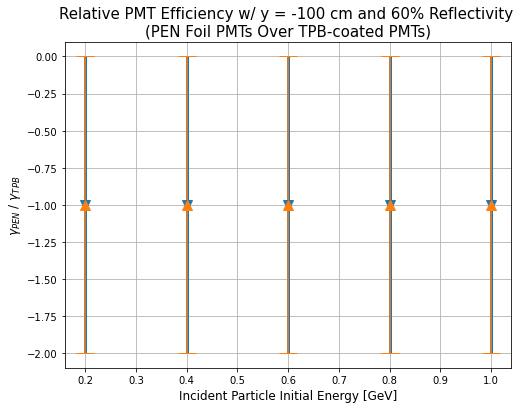

In [10]:
# Plot the efficiency versus energy data for 60% reflectivity in the photon library.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( energies, ref60_mean_efficiencies_vEng, yerr=ref60_mean_eff_errors_vEng, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( energies, ref60_mode_efficiencies_vEng, yerr=ref60_mode_eff_errors_vEng, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Incident Particle Initial Energy [GeV]", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and 60% Reflectivity \n(PEN Foil PMTs Over TPB-coated PMTs)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_eng, lin_fit_func( plot_range_eng, *popt_ref60_mean_vEng_lin), '-')
plt.plot( plot_range_eng, lin_fit_func( plot_range_eng, *popt_ref60_mode_vEng_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_ref60_mean_vEng_lin[0]:.2}*x +{popt_ref60_mean_vEng_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_ref60_mode_vEng_lin[0]:.2}*x +{popt_ref60_mode_vEng_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_partInitEnergy_PMT33OverPMT34_REF60_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ.jpeg")
plt.show()
plt.close()

NameError: name 'plot_range_eng' is not defined

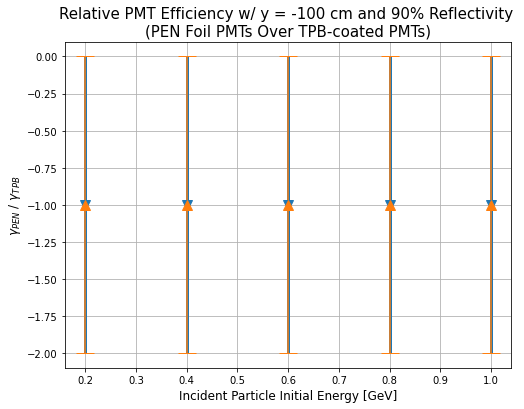

In [11]:
# Plot the efficiency versus energy data for 60% reflectivity in the photon library.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( energies, ref90_mean_efficiencies_vEng, yerr=ref90_mean_eff_errors_vEng, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( energies, ref90_mode_efficiencies_vEng, yerr=ref90_mode_eff_errors_vEng, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Incident Particle Initial Energy [GeV]", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and 90% Reflectivity \n(PEN Foil PMTs Over TPB-coated PMTs)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_eng, lin_fit_func( plot_range_eng, *popt_ref90_mean_vEng_lin), '-')
plt.plot( plot_range_eng, lin_fit_func( plot_range_eng, *popt_ref90_mode_vEng_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_ref90_mean_vEng_lin[0]:.2}*x +{popt_ref90_mean_vEng_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_ref90_mode_vEng_lin[0]:.2}*x +{popt_ref90_mode_vEng_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_partInitEnergy_PMT33OverPMT34_REF90_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ.jpeg")
plt.show()
plt.close()

### Plot of Efficiency v. Particle Initial y-distance to PMT Plane

This data is taken from simulations with the following file structure:
'REF40_-238X0_\<INIT_YPOS\>_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons' 
where \<INIT_YPOS\> is replaced with the appropriate formatted string version.

We use the ratio of PMT 33 to PMT 34 because it is the closest PMT pair to the incident particle's initial position in our simulations.

In [12]:
ydist_to_pmt_plane = np.abs( init_ypos - pmt_plane_ypos) # units in cm

# 'refXX' specifies reflectivity percentage.
# '_vDist' specifies that these arrays will be used when plotting efficiency 
# against y-distance between the incident particle and PMT plane (with fixed 
# incident particle initial energy, i.e. the incident particle's initial 
# energy is always set to 1 GeV).
ref40_eng1GeV_mean_efficiencies_vDist = np.full( len( init_ypos), -1.)
ref40_eng1GeV_mean_eff_errors_vDist   = np.full( len( init_ypos), -1.)
ref40_eng1GeV_mode_efficiencies_vDist = np.full( len( init_ypos), -1.)
ref40_eng1GeV_mode_eff_errors_vDist   = np.full( len( init_ypos), -1.)

In [13]:
ref40_eng1GeV_vDist_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in ref40_eng1GeV_vDist_file_ids])

# Note that pandas data frames cannot be put in a numpy array and keep
# their data frame formatting. I don't know why this happens, but we
# just use a regular list instead now.
ref40_eng1GeV_vDist_dfs = [ pd.read_csv( file) for file in ref40_eng1GeV_vDist_files]

# change first index in df.values to select different
# ratios of PMTs. The 0th ratio is closest to the
# incident particle's initial position (PMT 33 over
# PMT 34). The other pairs are as follows:
# 1: PMT 25 / PMT 26
# 2: PMT 20 / PMT 21
# 3: PMT 14 / PMT 15
# 4: PMT  9 / PMT 10
# 5: PMT  1 / PMT  2

for df, i in zip( ref40_eng1GeV_vDist_dfs, range(len(ref40_eng1GeV_vDist_dfs))):
    ref40_eng1GeV_mean_efficiencies_vDist[i]  = df.values[0,2]
    ref40_eng1GeV_mean_eff_errors_vDist[i]    = df.values[0,3]
    ref40_eng1GeV_mode_efficiencies_vDist[i]  = df.values[0,4]
    ref40_eng1GeV_mode_eff_errors_vDist[i]    = df.values[0,5]

FileNotFoundError: [Errno 2] No such file or directory: 'pmt_efficiency_data/PEN_over_TBP_PMT_efficienciesREF40_sim_-238X0_300Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons.csv'

In [14]:
# array used for plotting the fit data for all
# of the efficiency versus distance plots below
plot_range_dist = np.linspace( -1e-2, 1.1 * max( ydist_to_pmt_plane), 10000)

# fit the data for 40% reflectivity
popt_ref40_eng1GeV_mean_vDist_lin, pcov_ref40_eng1GeV_mean_vDist_lin = curve_fit(lin_fit_func, 
                                               ydist_to_pmt_plane, ref40_eng1GeV_mean_efficiencies_vDist,
                                               sigma=ref40_eng1GeV_mean_eff_errors_vDist,
                                               maxfev=1000000)
popt_ref40_eng1GeV_mode_vDist_lin, pcov_ref40_eng1GeV_mode_vDist_lin = curve_fit(lin_fit_func, 
                                               ydist_to_pmt_plane, ref40_eng1GeV_mode_efficiencies_vDist,
                                               sigma=ref40_eng1GeV_mode_eff_errors_vDist,
                                               maxfev=1000000)

/home/zsx17phys/miniconda3/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_partInitYDistToPMTPlane_PMT33OverPMT34_REF40_-238X0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0.jpeg'

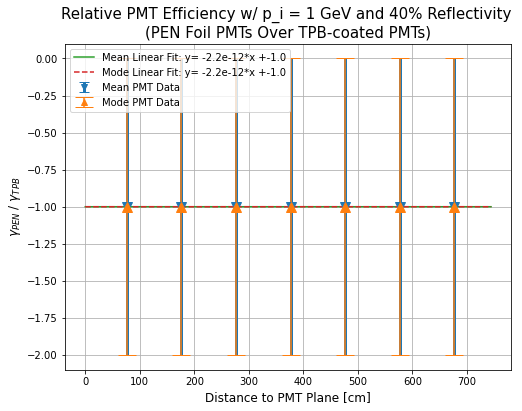

In [15]:
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( ydist_to_pmt_plane, ref40_eng1GeV_mean_efficiencies_vDist, yerr=ref40_eng1GeV_mean_eff_errors_vDist, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( ydist_to_pmt_plane, ref40_eng1GeV_mode_efficiencies_vDist, yerr=ref40_eng1GeV_mode_eff_errors_vDist, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Distance to PMT Plane [cm]", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ p_i = 1 GeV and 40% Reflectivity \n(PEN Foil PMTs Over TPB-coated PMTs)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_dist, lin_fit_func( plot_range_dist, *popt_ref40_eng1GeV_mean_vDist_lin), '-')
plt.plot( plot_range_dist, lin_fit_func( plot_range_dist, *popt_ref40_eng1GeV_mode_vDist_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_ref40_eng1GeV_mean_vDist_lin[0]:.2}*x +{popt_ref40_eng1GeV_mean_vDist_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_ref40_eng1GeV_mode_vDist_lin[0]:.2}*x +{popt_ref40_eng1GeV_mode_vDist_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_partInitYDistToPMTPlane_PMT33OverPMT34_REF40_-238X0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0.jpeg")
plt.show()
plt.close()

### Plot of Efficiency v. Photon Library Reflectivity

This data is taken from simulations with the following file structure:
'\<REFLECTIVITY\>\__-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_\<ENERGY\>GeVP0_muons' 
where \<REFLECTIVITY\> and \<ENERGY\> are replaced with the appropriate formatted string version.

We use the ratio of PMT 33 to PMT 34 because it is the closest PMT pair to the incident particle's initial position in our simulations.

In [ ]:
# '_vRef' specifies that these arrays will be used when plotting efficiency 
# against percent reflectivity for the different photon libraries
eng0pt2GeV_mean_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt2GeV_mean_eff_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt2GeV_mode_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt2GeV_mode_eff_errors_vRef   = np.full( len( reflectivities), -1.)

eng0pt4GeV_mean_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt4GeV_mean_eff_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt4GeV_mode_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt4GeV_mode_eff_errors_vRef   = np.full( len( reflectivities), -1.)

eng0pt6GeV_mean_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt6GeV_mean_eff_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt6GeV_mode_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt6GeV_mode_eff_errors_vRef   = np.full( len( reflectivities), -1.)

eng0pt8GeV_mean_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt8GeV_mean_eff_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt8GeV_mode_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng0pt8GeV_mode_eff_errors_vRef   = np.full( len( reflectivities), -1.)

eng1GeV_mean_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng1GeV_mean_eff_errors_vRef   = np.full( len( reflectivities), -1.)
eng1GeV_mode_efficiencies_vRef = np.full( len( reflectivities), -1.)
eng1GeV_mode_eff_errors_vRef   = np.full( len( reflectivities), -1.)

In [ ]:
eng0pt2GeV_vRef_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in eng0pt2GeV_vRef_file_ids])
eng0pt4GeV_vRef_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in eng0pt4GeV_vRef_file_ids])
eng0pt6GeV_vRef_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in eng0pt6GeV_vRef_file_ids])
eng0pt8GeV_vRef_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in eng0pt8GeV_vRef_file_ids])
eng1GeV_vRef_files = np.array( 
    ["pmt_efficiency_data/PEN_over_TBP_PMT_efficiencies"+ident+".csv" for ident in eng1GeV_vRef_file_ids])

# Note that pandas data frames cannot be put in a numpy array and keep
# their data frame formatting. I don't know why this happens, but we
# just use a regular list instead now.
eng0pt2GeV_vRef_dfs = [ pd.read_csv( file) for file in eng0pt2GeV_vRef_files]
eng0pt4GeV_vRef_dfs = [ pd.read_csv( file) for file in eng0pt4GeV_vRef_files]
eng0pt6GeV_vRef_dfs = [ pd.read_csv( file) for file in eng0pt6GeV_vRef_files]
eng0pt8GeV_vRef_dfs = [ pd.read_csv( file) for file in eng0pt8GeV_vRef_files]
eng1GeV_vRef_dfs = [ pd.read_csv( file) for file in eng1GeV_vRef_files]

# change first index in df.values to select different
# ratios of PMTs. The 0th ratio is closest to the
# incident particle's initial position (PMT 33 over
# PMT 34). The other pairs are as follows:
# 1: PMT 25 / PMT 26
# 2: PMT 20 / PMT 21
# 3: PMT 14 / PMT 15
# 4: PMT  9 / PMT 10
# 5: PMT  1 / PMT  2

for df, i in zip( eng0pt2GeV_vRef_dfs, range(len(eng0pt2GeV_vRef_dfs))):
    eng0pt2GeV_mean_efficiencies_vRef[i]  = df.values[0,2]
    eng0pt2GeV_mean_eff_errors_vRef[i]    = df.values[0,3]
    eng0pt2GeV_mode_efficiencies_vRef[i]  = df.values[0,4]
    eng0pt2GeV_mode_eff_errors_vRef[i]    = df.values[0,5]
    
for df, i in zip( eng0pt4GeV_vRef_dfs, range(len(eng0pt4GeV_vRef_dfs))):
    eng0pt4GeV_mean_efficiencies_vRef[i]  = df.values[0,2]
    eng0pt4GeV_mean_eff_errors_vRef[i]    = df.values[0,3]
    eng0pt4GeV_mode_efficiencies_vRef[i]  = df.values[0,4]
    eng0pt4GeV_mode_eff_errors_vRef[i]    = df.values[0,5]
    
for df, i in zip( eng0pt6GeV_vRef_dfs, range(len(eng0pt6GeV_vRef_dfs))):
    eng0pt6GeV_mean_efficiencies_vRef[i]  = df.values[0,2]
    eng0pt6GeV_mean_eff_errors_vRef[i]    = df.values[0,3]
    eng0pt6GeV_mode_efficiencies_vRef[i]  = df.values[0,4]
    eng0pt6GeV_mode_eff_errors_vRef[i]    = df.values[0,5]
    
for df, i in zip( eng0pt8GeV_vRef_dfs, range(len(eng0pt8GeV_vRef_dfs))):
    eng0pt8GeV_mean_efficiencies_vRef[i]  = df.values[0,2]
    eng0pt8GeV_mean_eff_errors_vRef[i]    = df.values[0,3]
    eng0pt8GeV_mode_efficiencies_vRef[i]  = df.values[0,4]
    eng0pt8GeV_mode_eff_errors_vRef[i]    = df.values[0,5]
    
for df, i in zip( eng1GeV_vRef_dfs, range(len(eng1GeV_vRef_dfs))):
    eng1GeV_mean_efficiencies_vRef[i]  = df.values[0,2]
    eng1GeV_mean_eff_errors_vRef[i]    = df.values[0,3]
    eng1GeV_mode_efficiencies_vRef[i]  = df.values[0,4]
    eng1GeV_mode_eff_errors_vRef[i]    = df.values[0,5]

In [ ]:
# array used for plotting the fit data for all
# of the efficiency versus reflectivity plots below
plot_range_ref = np.linspace( 0, 100, 10000)

# fit the data for an initial particle energy of 0.2 GeV
popt_eng0pt2GeV_mean_vRef_lin, pcov_eng0pt2GeV_mean_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt2GeV_mean_efficiencies_vRef,
                                               sigma=eng0pt2GeV_mean_eff_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt2GeV_mode_vRef_lin, pcov_eng0pt2GeV_mode_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt2GeV_mode_efficiencies_vRef,
                                               sigma=eng0pt2GeV_mode_eff_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 0.4 GeV
popt_eng0pt4GeV_mean_vRef_lin, pcov_eng0pt4GeV_mean_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt4GeV_mean_efficiencies_vRef,
                                               sigma=eng0pt4GeV_mean_eff_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt4GeV_mode_vRef_lin, pcov_eng0pt4GeV_mode_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt4GeV_mode_efficiencies_vRef,
                                               sigma=eng0pt4GeV_mode_eff_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 0.6 GeV
popt_eng0pt6GeV_mean_vRef_lin, pcov_eng0pt6GeV_mean_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt6GeV_mean_efficiencies_vRef,
                                               sigma=eng0pt6GeV_mean_eff_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt6GeV_mode_vRef_lin, pcov_eng0pt6GeV_mode_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt6GeV_mode_efficiencies_vRef,
                                               sigma=eng0pt6GeV_mode_eff_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 0.8 GeV
popt_eng0pt8GeV_mean_vRef_lin, pcov_eng0pt8GeV_mean_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt8GeV_mean_efficiencies_vRef,
                                               sigma=eng0pt8GeV_mean_eff_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt8GeV_mode_vRef_lin, pcov_eng0pt8GeV_mode_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt8GeV_mode_efficiencies_vRef,
                                               sigma=eng0pt8GeV_mode_eff_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 1 GeV
popt_eng1GeV_mean_vRef_lin, pcov_eng1GeV_mean_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng1GeV_mean_efficiencies_vRef,
                                               sigma=eng1GeV_mean_eff_errors_vRef,
                                               maxfev=1000000)
popt_eng1GeV_mode_vRef_lin, pcov_eng1GeV_mode_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng1GeV_mode_efficiencies_vRef,
                                               sigma=eng1GeV_mode_eff_errors_vRef,
                                               maxfev=1000000)

In [ ]:
# Plot the efficiency versus reflectivity data for 0.2 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt2GeV_mean_efficiencies_vRef, yerr=eng0pt2GeV_mean_eff_errors_vRef, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt2GeV_mode_efficiencies_vRef, yerr=eng0pt2GeV_mode_eff_errors_vRef, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and p_i = 0.2 GeV \n(PEN Foil PMTs Over TPB-coated PMTs)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt2GeV_mean_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt2GeV_mode_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt2GeV_mean_vRef_lin[0]:.2}*x +{popt_eng0pt2GeV_mean_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt2GeV_mode_vRef_lin[0]:.2}*x +{popt_eng0pt2GeV_mode_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_reflectivity_PMT33OverPMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt2GeVP0.jpeg")
plt.show()
plt.close()

In [ ]:
# Plot the efficiency versus reflectivity data for 0.4 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt4GeV_mean_efficiencies_vRef, yerr=eng0pt4GeV_mean_eff_errors_vRef, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt4GeV_mode_efficiencies_vRef, yerr=eng0pt4GeV_mode_eff_errors_vRef, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and p_i = 0.4 GeV \n(PEN Foil PMTs Over TPB-coated PMTs)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt4GeV_mean_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt4GeV_mode_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt4GeV_mean_vRef_lin[0]:.2}*x +{popt_eng0pt4GeV_mean_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt4GeV_mode_vRef_lin[0]:.2}*x +{popt_eng0pt4GeV_mode_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_reflectivity_PMT33OverPMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt4GeVP0.jpeg")
plt.show()
plt.close()

In [ ]:
# Plot the efficiency versus reflectivity data for 0.6 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt6GeV_mean_efficiencies_vRef, yerr=eng0pt6GeV_mean_eff_errors_vRef, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt6GeV_mode_efficiencies_vRef, yerr=eng0pt6GeV_mode_eff_errors_vRef, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and p_i = 0.6 GeV \n(PEN Foil PMTs Over TPB-coated PMTs)", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt6GeV_mean_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt6GeV_mode_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt6GeV_mean_vRef_lin[0]:.2}*x +{popt_eng0pt6GeV_mean_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt6GeV_mode_vRef_lin[0]:.2}*x +{popt_eng0pt6GeV_mode_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_reflectivity_PMT33OverPMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt6GeVP0.jpeg")
plt.show()
plt.close()

In [ ]:
# Plot the efficiency versus reflectivity data for 0.8 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt8GeV_mean_efficiencies_vRef, yerr=eng0pt8GeV_mean_eff_errors_vRef, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt8GeV_mode_efficiencies_vRef, yerr=eng0pt8GeV_mode_eff_errors_vRef, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and p_i = 0.8 GeV \n(PEN Foil PMTs Over TPB-coated PMTs)", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt8GeV_mean_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt8GeV_mode_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt8GeV_mean_vRef_lin[0]:.2}*x +{popt_eng0pt8GeV_mean_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt8GeV_mode_vRef_lin[0]:.2}*x +{popt_eng0pt8GeV_mode_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_reflectivity_PMT33OverPMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt8GeVP0.jpeg")
plt.show()
plt.close()

In [ ]:
# Plot the efficiency versus reflectivity data for 1 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng1GeV_mean_efficiencies_vRef, yerr=eng1GeV_mean_eff_errors_vRef, 
             fmt='v', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng1GeV_mode_efficiencies_vRef, yerr=eng1GeV_mode_eff_errors_vRef, 
             fmt='^', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel(r"$\gamma_{PEN}$ / $\gamma_{TPB}$", fontsize=12)
plt.title(f"Relative PMT Efficiency w/ y = -100 cm and p_i = 1 GeV \n(PEN Foil PMTs Over TPB-coated PMTs)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng1GeV_mean_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng1GeV_mode_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng1GeV_mean_vRef_lin[0]:.2}*x +{popt_eng1GeV_mean_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng1GeV_mode_vRef_lin[0]:.2}*x +{popt_eng1GeV_mode_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_relativePMTEff_versus_reflectivity_PMT33OverPMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0.jpeg")
plt.show()
plt.close()

### Plot of Denominator (TPB-coated) PMT Counts v. Photon Library Reflectivity

Because of the geometry of the PEN and TPB PMTs, we know that the PEN PMTs should receive 30% more photons at the LArG4 stage as outlined in section 3.3 (page 15) of [arXiv 2203.16134](https://arxiv.org/abs/2203.16134). But we DO NOT know what reflectivity was used in the photon library for this simulation, and we do not know the initial energy of the incident particle(s). We have shown above that the distance between the initial y-position of the incident particle and the PMT plane does not significantly affect our efficiency measurements (at least at 40% reflectivity). But efficiency is arguably a function of energy and especially a function of reflectivity. 

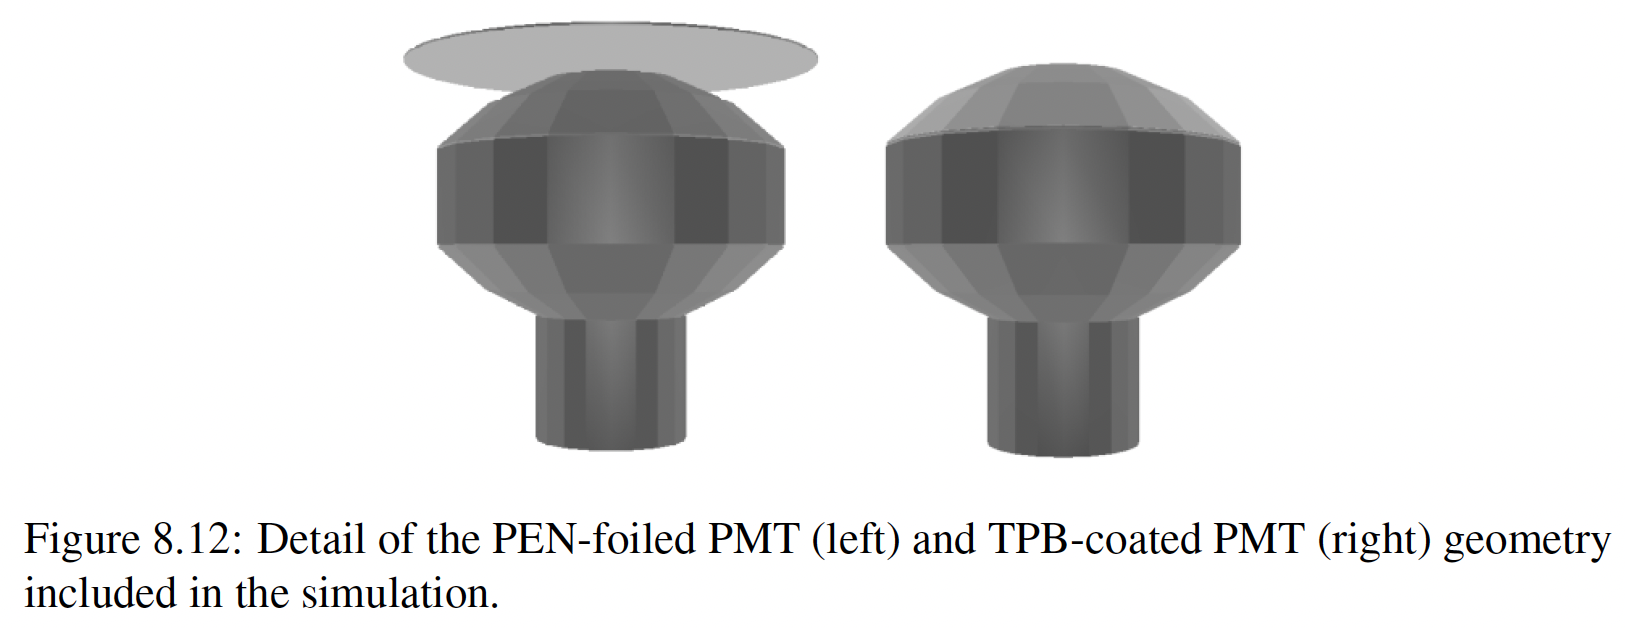
This figure shows how the PEN PMTs have two exposed faces. Since photons arriving at the PMT WLSs are not reemitted (detsim and reco stages may do this), the extra photons arriving at the PEN PMTs must be reflected off the bottom and captured on the underside exposed face of the PEN PMT WLS. 

The lack of dependence on distance is likely due to how the PMT plane is close to the bottom inside face of the detector. Theoretically, there should be energy, distance, and reflectivity combinations where most of the photons that pass through the PMT plane going in the -y direction do not have enough energy (for a given reflectivity) to make it through the small amount of liquid argon between the PMT plane and the bottom of the inside of the detector. 

As we increase the reflectivity, the total number of photons hitting the underside of the PEN PMT WLSs likely increases. This section is to test that the TPB-coated PMTs do not see an increase in the raw number of photons reaching the WLS as a function of reflectivity since the TPB-coated PMTs only have an exposed WLS face that is orientated upwards.

This data is taken from simulations with the following file structure:
'\<REFLECTIVITY\>\__-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_\<ENERGY\>GeVP0_muons' 
where \<REFLECTIVITY\> and \<ENERGY\> are replaced with the appropriate formatted string version.

We mainly rely on PMT 34 because it is part of the the PMT pair we have been using for this analysis so far. PMT 34 is part of a good PMT pair (with PMT 33) given the set of simulation initial parameters (e.g. muon position, energy, angle, etc.). Since we have established that the efficiency ratio does not strongly depend on the incident particle's initial distance to the PMT plane, we should in theory be able to use any of the PMT pairs (this is dependent on your initial particle's starting position, angles, etc.) instead of just PMT 33 and PMT 34.

In [ ]:
# '_vRef' specifies that these arrays will be used when plotting PMT
# photon count against percent reflectivity for the different photon 
# libraries
eng0pt2GeV_mean_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt2GeV_mean_count_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt2GeV_mode_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt2GeV_mode_count_errors_vRef   = np.full( len( reflectivities), -1.)

eng0pt4GeV_mean_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt4GeV_mean_count_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt4GeV_mode_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt4GeV_mode_count_errors_vRef   = np.full( len( reflectivities), -1.)

eng0pt6GeV_mean_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt6GeV_mean_count_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt6GeV_mode_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt6GeV_mode_count_errors_vRef   = np.full( len( reflectivities), -1.)

eng0pt8GeV_mean_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt8GeV_mean_count_errors_vRef   = np.full( len( reflectivities), -1.)
eng0pt8GeV_mode_count_vRef          = np.full( len( reflectivities), -1.)
eng0pt8GeV_mode_count_errors_vRef   = np.full( len( reflectivities), -1.)

eng1GeV_mean_count_vRef             = np.full( len( reflectivities), -1.)
eng1GeV_mean_count_errors_vRef      = np.full( len( reflectivities), -1.)
eng1GeV_mode_count_vRef             = np.full( len( reflectivities), -1.)
eng1GeV_mode_count_errors_vRef      = np.full( len( reflectivities), -1.)

In [ ]:
eng0pt2GeV_vRef_rawCount_files = np.array( 
    ["pmt_data_files/pDUNE_DP_VD_optical_nowires_"+ident+"_PMT_data.csv" for ident in eng0pt2GeV_vRef_file_ids])
eng0pt4GeV_vRef_rawCount_files = np.array( 
    ["pmt_data_files/pDUNE_DP_VD_optical_nowires_"+ident+"_PMT_data.csv" for ident in eng0pt4GeV_vRef_file_ids])
eng0pt6GeV_vRef_rawCount_files = np.array( 
    ["pmt_data_files/pDUNE_DP_VD_optical_nowires_"+ident+"_PMT_data.csv" for ident in eng0pt6GeV_vRef_file_ids])
eng0pt8GeV_vRef_rawCount_files = np.array( 
    ["pmt_data_files/pDUNE_DP_VD_optical_nowires_"+ident+"_PMT_data.csv" for ident in eng0pt8GeV_vRef_file_ids])
eng1GeV_vRef_rawCount_files = np.array( 
    ["pmt_data_files/pDUNE_DP_VD_optical_nowires_"+ident+"_PMT_data.csv" for ident in eng1GeV_vRef_file_ids])

# Note that pandas data frames cannot be put in a numpy array and keep
# their data frame formatting. I don't know why this happens, but we
# just use a regular list instead now.
eng0pt2GeV_vRef_rawCount_dfs = [ pd.read_csv( file) for file in eng0pt2GeV_vRef_rawCount_files]
eng0pt4GeV_vRef_rawCount_dfs = [ pd.read_csv( file) for file in eng0pt4GeV_vRef_rawCount_files]
eng0pt6GeV_vRef_rawCount_dfs = [ pd.read_csv( file) for file in eng0pt6GeV_vRef_rawCount_files]
eng0pt8GeV_vRef_rawCount_dfs = [ pd.read_csv( file) for file in eng0pt8GeV_vRef_rawCount_files]
eng1GeV_vRef_rawCount_dfs = [ pd.read_csv( file) for file in eng1GeV_vRef_rawCount_files]

for df, i in zip( eng0pt2GeV_vRef_rawCount_dfs, range(len(eng0pt2GeV_vRef_rawCount_dfs))):
    eng0pt2GeV_mean_count_vRef[i] = df.values[34,1]
    eng0pt2GeV_mean_count_errors_vRef[i] = np.sqrt( df.values[34,1])
    eng0pt2GeV_mode_count_vRef[i] = df.values[34,2]
    eng0pt2GeV_mode_count_errors_vRef[i] = np.sqrt( df.values[34,2])
    
for df, i in zip( eng0pt4GeV_vRef_rawCount_dfs, range(len(eng0pt4GeV_vRef_rawCount_dfs))):
    eng0pt4GeV_mean_count_vRef[i] = df.values[34,1]
    eng0pt4GeV_mean_count_errors_vRef[i] = np.sqrt( df.values[34,1])
    eng0pt4GeV_mode_count_vRef[i] = df.values[34,2]
    eng0pt4GeV_mode_count_errors_vRef[i] = np.sqrt( df.values[34,2])
    
for df, i in zip( eng0pt6GeV_vRef_rawCount_dfs, range(len(eng0pt6GeV_vRef_rawCount_dfs))):
    eng0pt6GeV_mean_count_vRef[i] = df.values[34,1]
    eng0pt6GeV_mean_count_errors_vRef[i] = np.sqrt( df.values[34,1])
    eng0pt6GeV_mode_count_vRef[i] = df.values[34,2]
    eng0pt6GeV_mode_count_errors_vRef[i] = np.sqrt( df.values[34,2])
    
for df, i in zip( eng0pt8GeV_vRef_rawCount_dfs, range(len(eng0pt8GeV_vRef_rawCount_dfs))):
    eng0pt8GeV_mean_count_vRef[i] = df.values[34,1]
    eng0pt8GeV_mean_count_errors_vRef[i] = np.sqrt( df.values[34,1])
    eng0pt8GeV_mode_count_vRef[i] = df.values[34,2]
    eng0pt8GeV_mode_count_errors_vRef[i] = np.sqrt( df.values[34,2])
    
for df, i in zip( eng1GeV_vRef_rawCount_dfs, range(len(eng1GeV_vRef_rawCount_dfs))):
    eng1GeV_mean_count_vRef[i] = df.values[34,1]
    eng1GeV_mean_count_errors_vRef[i] = np.sqrt( df.values[34,1])
    eng1GeV_mode_count_vRef[i] = df.values[34,2]
    eng1GeV_mode_count_errors_vRef[i] = np.sqrt( df.values[34,2])

In [ ]:
# fit the data for an initial particle energy of 0.2 GeV
popt_eng0pt2GeV_mean_count_vRef_lin, pcov_eng0pt2GeV_mean_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt2GeV_mean_count_vRef,
                                               sigma=eng0pt2GeV_mean_count_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt2GeV_mode_count_vRef_lin, pcov_eng0pt2GeV_mode_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt2GeV_mode_count_vRef,
                                               sigma=eng0pt2GeV_mode_count_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 0.4 GeV
popt_eng0pt4GeV_mean_count_vRef_lin, pcov_eng0pt4GeV_mean_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt4GeV_mean_count_vRef,
                                               sigma=eng0pt4GeV_mean_count_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt4GeV_mode_count_vRef_lin, pcov_eng0pt4GeV_mode_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt4GeV_mode_count_vRef,
                                               sigma=eng0pt4GeV_mode_count_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 0.6 GeV
popt_eng0pt6GeV_mean_count_vRef_lin, pcov_eng0pt6GeV_mean_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt6GeV_mean_count_vRef,
                                               sigma=eng0pt6GeV_mean_count_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt6GeV_mode_count_vRef_lin, pcov_eng0pt6GeV_mode_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt6GeV_mode_count_vRef,
                                               sigma=eng0pt6GeV_mode_count_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 0.8 GeV
popt_eng0pt8GeV_mean_count_vRef_lin, pcov_eng0pt8GeV_mean_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt8GeV_mean_count_vRef,
                                               sigma=eng0pt8GeV_mean_count_errors_vRef,
                                               maxfev=1000000)
popt_eng0pt8GeV_mode_count_vRef_lin, pcov_eng0pt8GeV_mode_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng0pt8GeV_mode_count_vRef,
                                               sigma=eng0pt8GeV_mode_count_errors_vRef,
                                               maxfev=1000000)

# fit the data for an initial particle energy of 1.0 GeV
popt_eng1GeV_mean_count_vRef_lin, pcov_eng1GeV_mean_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng1GeV_mean_count_vRef,
                                               sigma=eng1GeV_mean_count_errors_vRef,
                                               maxfev=1000000)
popt_eng1GeV_mode_count_vRef_lin, pcov_eng1GeV_mode_count_vRef_lin = curve_fit(lin_fit_func, 
                                               reflectivities, eng1GeV_mode_count_vRef,
                                               sigma=eng1GeV_mode_count_errors_vRef,
                                               maxfev=1000000)

In [ ]:
# Plot the efficiency versus reflectivity data for 0.2 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt2GeV_mean_count_vRef, yerr=eng0pt2GeV_mean_count_errors_vRef, 
             fmt='s', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt2GeV_mode_count_vRef, yerr=eng0pt2GeV_mode_count_errors_vRef, 
             fmt='d', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity \ny = -100 cm and p_i = 0.2 GeV", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt2GeV_mean_count_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt2GeV_mode_count_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt2GeV_mean_count_vRef_lin[0]:.2}*x +{popt_eng0pt2GeV_mean_count_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt2GeV_mode_count_vRef_lin[0]:.2}*x +{popt_eng0pt2GeV_mode_count_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCount_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt2GeVP0.jpeg")
plt.show()
plt.close()

In [ ]:
# Plot the efficiency versus reflectivity data for 0.4 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt4GeV_mean_count_vRef, yerr=eng0pt4GeV_mean_count_errors_vRef, 
             fmt='s', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt4GeV_mode_count_vRef, yerr=eng0pt4GeV_mode_count_errors_vRef, 
             fmt='d', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity \ny = -100 cm and p_i = 0.4 GeV", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt4GeV_mean_count_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt4GeV_mode_count_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt4GeV_mean_count_vRef_lin[0]:.2}*x +{popt_eng0pt4GeV_mean_count_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt4GeV_mode_count_vRef_lin[0]:.2}*x +{popt_eng0pt4GeV_mode_count_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCount_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt4GeVP0.jpeg")
plt.show()
plt.close()

In [ ]:
# Plot the efficiency versus reflectivity data for 0.6 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt6GeV_mean_count_vRef, yerr=eng0pt6GeV_mean_count_errors_vRef, 
             fmt='s', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt6GeV_mode_count_vRef, yerr=eng0pt6GeV_mode_count_errors_vRef, 
             fmt='d', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity \ny = -100 cm and p_i = 0.6 GeV", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt6GeV_mean_count_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt6GeV_mode_count_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt6GeV_mean_count_vRef_lin[0]:.2}*x +{popt_eng0pt6GeV_mean_count_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt6GeV_mode_count_vRef_lin[0]:.2}*x +{popt_eng0pt6GeV_mode_count_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCount_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt6GeVP0.jpeg")
plt.show()
plt.close()

In [16]:
# Plot the efficiency versus reflectivity data for 0.8 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt8GeV_mean_count_vRef, yerr=eng0pt8GeV_mean_count_errors_vRef, 
             fmt='s', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt8GeV_mode_count_vRef, yerr=eng0pt8GeV_mode_count_errors_vRef, 
             fmt='d', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity \ny = -100 cm and p_i = 0.8 GeV", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt8GeV_mean_count_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt8GeV_mode_count_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng0pt8GeV_mean_count_vRef_lin[0]:.2}*x +{popt_eng0pt8GeV_mean_count_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng0pt8GeV_mode_count_vRef_lin[0]:.2}*x +{popt_eng0pt8GeV_mode_count_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCount_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0pt8GeVP0.jpeg")
plt.show()
plt.close()

NameError: name 'eng0pt8GeV_mean_count_vRef' is not defined

<Figure size 576x432 with 0 Axes>

In [17]:
# Plot the efficiency versus reflectivity data for 1.0 GeV data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng1GeV_mean_count_vRef, yerr=eng1GeV_mean_count_errors_vRef, 
             fmt='s', capsize=5, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng1GeV_mode_count_vRef, yerr=eng1GeV_mode_count_errors_vRef, 
             fmt='d', capsize=9, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity \ny = -100 cm and p_i = 1.0 GeV", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng1GeV_mean_count_vRef_lin), '-')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng1GeV_mode_count_vRef_lin), '--')

plt.legend([f'Mean Linear Fit: y= {popt_eng1GeV_mean_count_vRef_lin[0]:.2}*x +{popt_eng1GeV_mean_count_vRef_lin[1]:.3}', 
            f'Mode Linear Fit: y= {popt_eng1GeV_mode_count_vRef_lin[0]:.2}*x +{popt_eng1GeV_mode_count_vRef_lin[1]:.3}', 
            'Mean PMT Data', 
            'Mode PMT Data'],
            markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCount_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0.jpeg")
plt.show()
plt.close()

NameError: name 'eng1GeV_mean_count_vRef' is not defined

<Figure size 576x432 with 0 Axes>

In [18]:
# Plot the mean efficiency versus reflectivity data for all of the energy data points.
plt.figure( figsize=(8, 6))

# plot the color-coded data
plt.errorbar( reflectivities, eng0pt2GeV_mean_count_vRef, yerr=eng0pt2GeV_mean_count_errors_vRef, 
             fmt='s', c='red', capsize=15, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt4GeV_mean_count_vRef, yerr=eng0pt4GeV_mean_count_errors_vRef, 
             fmt='s', c='cyan', capsize=15, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt6GeV_mean_count_vRef, yerr=eng0pt6GeV_mean_count_errors_vRef, 
             fmt='s', c='green', capsize=15, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng0pt8GeV_mean_count_vRef, yerr=eng0pt8GeV_mean_count_errors_vRef, 
             fmt='s', c='purple', capsize=15, markersize=10, elinewidth=3)
plt.errorbar( reflectivities, eng1GeV_mean_count_vRef, yerr=eng1GeV_mean_count_errors_vRef, 
             fmt='s', c='pink', capsize=15, markersize=10, elinewidth=3)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity (y = -100 cm)",
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt2GeV_mean_count_vRef_lin), '-',  c='red')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt4GeV_mean_count_vRef_lin), '-',  c='cyan')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt6GeV_mean_count_vRef_lin), '-',  c='green')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt8GeV_mean_count_vRef_lin), '-',  c='purple')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng1GeV_mean_count_vRef_lin), '-',  c='pink')

mean_legend_elements = [Line2D([0], [0], color='black', linestyle='-', lw=2, label='Mean Fit'),
                   Line2D([0], [0], marker='s', color='white', label='Mean Data',
                          markerfacecolor='black', markersize=15),
                   Patch(facecolor='red', edgecolor='black', label='0.2 GeV'),
                   Patch(facecolor='cyan', edgecolor='black', label='0.4 GeV'),
                   Patch(facecolor='green', edgecolor='black', label='0.6 GeV'),
                   Patch(facecolor='purple', edgecolor='black', label='0.8 GeV'),
                   Patch(facecolor='pink', edgecolor='black', label='1.0 GeV')]

plt.legend( handles=mean_legend_elements, markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCountMean_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ.jpeg")
plt.show()
plt.close()

NameError: name 'eng0pt2GeV_mean_count_vRef' is not defined

<Figure size 576x432 with 0 Axes>

In [19]:
# Plot the mode efficiency versus reflectivity data for all of the energy data points.
plt.figure( figsize=(8, 6))

plt.errorbar( reflectivities, eng0pt2GeV_mode_count_vRef, yerr=eng0pt2GeV_mode_count_errors_vRef, 
             fmt='d', c='red', capsize=15, markersize=10)
plt.errorbar( reflectivities, eng0pt4GeV_mode_count_vRef, yerr=eng0pt4GeV_mode_count_errors_vRef, 
             fmt='d', c='cyan', capsize=15, markersize=10)
plt.errorbar( reflectivities, eng0pt6GeV_mode_count_vRef, yerr=eng0pt6GeV_mode_count_errors_vRef, 
             fmt='d', c='green', capsize=15, markersize=10)
plt.errorbar( reflectivities, eng0pt8GeV_mode_count_vRef, yerr=eng0pt8GeV_mode_count_errors_vRef, 
             fmt='d', c='purple', capsize=15, markersize=10)
plt.errorbar( reflectivities, eng1GeV_mode_count_vRef, yerr=eng1GeV_mode_count_errors_vRef, 
             fmt='d', c='pink', capsize=15, markersize=10)

# make the plot look pretty
plt.xlabel("Percent Reflectivity", fontsize=12)
plt.ylabel("Number of Photons", fontsize=12)
plt.title(f"Photon Count in PMT 34 v. Reflectivity (y = -100 cm)", 
          fontsize=15)
plt.grid()

plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt2GeV_mode_count_vRef_lin), '--', c='red')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt4GeV_mode_count_vRef_lin), '--', c='cyan')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt6GeV_mode_count_vRef_lin), '--', c='green')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng0pt8GeV_mode_count_vRef_lin), '--', c='purple')
plt.plot( plot_range_ref, lin_fit_func( plot_range_ref, *popt_eng1GeV_mode_count_vRef_lin), '--', c='pink')

mode_legend_elements = [Line2D([0], [0], color='black', linestyle='--', lw=2, label='Mode Fit'),
                   Line2D([0], [0], marker='d', color='white', label='Mode Data',
                          markerfacecolor='black', markersize=15),
                   Patch(facecolor='red', edgecolor='black', label='0.2 GeV'),
                   Patch(facecolor='cyan', edgecolor='black', label='0.4 GeV'),
                   Patch(facecolor='green', edgecolor='black', label='0.6 GeV'),
                   Patch(facecolor='purple', edgecolor='black', label='0.8 GeV'),
                   Patch(facecolor='pink', edgecolor='black', label='1.0 GeV')]

plt.legend( handles=mode_legend_elements, markerscale=0.6, labelspacing=0.5)

# save the figure
plt.savefig("/Users/jacob/Desktop/SBU_Research/plots/pDUNE_DP_VD_photonCountMode_versus_reflectivity_PMT34_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ.jpeg")
plt.show()
plt.close()

NameError: name 'eng0pt2GeV_mode_count_vRef' is not defined

<Figure size 576x432 with 0 Axes>

Here we see that the number of photons in PMT 34 is not constant as a function of reflectivity. In retrospect, this makes some amount of sense since photons reflected off the bottom inner surface of the detector are still interacting with liquid argon and have a chance to randomly scatter (really, I think the photon is absorbed and then re-emitted) in any direction off of an atom of argon. From these plots we can infer that the photon counts in PMT 33 are increasing more rapidly than we see in PMT 34. We can say this because we see that the ratio of PMT 33 over PMT 34 is increasing as a function of reflectivity. Then again, we could have made these statements only by looking at the efficiency plots.

### Plot of PMT Counts v. Particle Initial y-distance to PMT Plane

This data is taken from simulations with the following file structure:
'REF40_-238X0_\<INIT_YPOS\>_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons' 
where \<INIT_YPOS\> is replaced with the appropriate formatted string version.

In [20]:
# '_vDist' specifies that these arrays will be used when plotting PMT 
# photon count against the difference between the incident particle's
# initial y-position and the y-position of the PMT plane.
ref40_eng1GeV_mean_count_vDist             = np.full( ( num_pmts, len( init_ypos)), -1.)
ref40_eng1GeV_mean_count_errors_vDist      = np.full( ( num_pmts, len( init_ypos)), -1.)
ref40_eng1GeV_mode_count_vDist             = np.full( ( num_pmts, len( init_ypos)), -1.)
ref40_eng1GeV_mode_count_errors_vDist      = np.full( ( num_pmts, len( init_ypos)), -1.)

In [21]:
ref40_eng1GeV_vDist_rawCount_files = np.array( 
    ["pmt_data_files/pDUNE_DP_VD_optical_nowires_"+ident+"_PMT_data.csv" for ident in ref40_eng1GeV_vDist_file_ids])

# Note that pandas data frames cannot be put in a numpy array and keep
# their data frame formatting. I don't know why this happens, but we
# just use a regular list instead now.
ref40_eng1GeV_vDist_rawCount_dfs = [ pd.read_csv( file) for file in ref40_eng1GeV_vDist_rawCount_files]

    
for df, i in zip( ref40_eng1GeV_vDist_rawCount_dfs, range(len(ref40_eng1GeV_vDist_rawCount_dfs))):
    for j in range( num_pmts):
        ref40_eng1GeV_mean_count_vDist[j, i]        =          df.values[j, 1]
        ref40_eng1GeV_mean_count_errors_vDist[j, i] = np.sqrt( df.values[j, 1])
        ref40_eng1GeV_mode_count_vDist[j, i]        =          df.values[j, 2]
        ref40_eng1GeV_mode_count_errors_vDist[j, i] = np.sqrt( df.values[j, 2])

FileNotFoundError: [Errno 2] No such file or directory: 'pmt_data_files/pDUNE_DP_VD_optical_nowires_REF40_sim_-238X0_300Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons_PMT_data.csv'

In [22]:
for j in range( num_pmts):
    # fit the data for an initial particle energy of 1.0 GeV and 40% reflectivity
    popt_ref40_eng1GeV_mean_count_vDist_exp, pcov_ref40_eng1GeV_mean_count_vDist_exp = curve_fit( exp_fit_func, 
                                               ydist_to_pmt_plane, ref40_eng1GeV_mean_count_vDist[j,:],
                                               sigma=ref40_eng1GeV_mean_count_errors_vDist[j,:],
                                               p0=( max( ref40_eng1GeV_mean_count_vDist[j,:]), -99, 0),
                                               bounds=(
                                                   [0, -120, 0], 
                                                   [100*max( ref40_eng1GeV_mean_count_vDist[j,:]), -80, max( ref40_eng1GeV_mean_count_vDist[j,:])]),
                                               maxfev=1000000)
    popt_ref40_eng1GeV_mode_count_vDist_exp, pcov_ref40_eng1GeV_mode_count_vDist_exp = curve_fit( exp_fit_func, 
                                               ydist_to_pmt_plane, ref40_eng1GeV_mode_count_vDist[j,:],
                                               sigma=ref40_eng1GeV_mode_count_errors_vDist[j,:],
                                               p0=( max( ref40_eng1GeV_mean_count_vDist[j,:]), -99, 0),
                                               bounds=(
                                                   [0, -120, 0], 
                                                   [100*max( ref40_eng1GeV_mean_count_vDist[j,:]), -80, max( ref40_eng1GeV_mean_count_vDist[j,:])]),
                                               maxfev=1000000)
    
    # calculate the chi-square per degree of freedom for each of the fits
    dof_mean = len( init_ypos) - len( popt_ref40_eng1GeV_mean_count_vDist_exp)
    dof_mode = len( init_ypos) - len( popt_ref40_eng1GeV_mode_count_vDist_exp)
        
    chi2_mean = np.sum( 
        np.square( 
            ref40_eng1GeV_mean_count_vDist[j,:] 
            - exp_fit_func( ydist_to_pmt_plane, *popt_ref40_eng1GeV_mean_count_vDist_exp)) \
        / np.square( ref40_eng1GeV_mean_count_errors_vDist))
    
    chi2_mode = np.sum( 
        np.square( 
            ref40_eng1GeV_mode_count_vDist[j,:] 
            - exp_fit_func( ydist_to_pmt_plane, *popt_ref40_eng1GeV_mode_count_vDist_exp)) \
        / np.square( ref40_eng1GeV_mode_count_errors_vDist))
    
    # Plot the efficiency versus reflectivity data for 0.8 GeV data points.
    plt.figure( figsize=(8, 6))

    # plot the color-coded data
    plt.errorbar( ydist_to_pmt_plane, ref40_eng1GeV_mean_count_vDist[j,:], yerr=ref40_eng1GeV_mean_count_errors_vDist[j,:], 
                 fmt='s', capsize=5, markersize=10, elinewidth=3)
    plt.errorbar( ydist_to_pmt_plane, ref40_eng1GeV_mode_count_vDist[j,:], yerr=ref40_eng1GeV_mode_count_errors_vDist[j,:], 
                 fmt='d', capsize=9, markersize=10)

    # make the plot look pretty
    plt.xlabel("Distance to PMT Plane [cm]", fontsize=12)
    plt.ylabel("Number of Photons", fontsize=12)
    plt.title(f"Photon Count in PMT {j} v. Distance to PMT Plane \n w/ 40% Reflectivity and p_i = 1.0 GeV", 
              fontsize=15)
    plt.grid()

    plt.plot( plot_range_dist, exp_fit_func( plot_range_dist, *popt_ref40_eng1GeV_mean_count_vDist_exp), '-')
    plt.plot( plot_range_dist, exp_fit_func( plot_range_dist, *popt_ref40_eng1GeV_mode_count_vDist_exp), '--')

    plt.legend([f'Mean Exponential Fit: y= {popt_ref40_eng1GeV_mean_count_vDist_exp[0]:.2}*e^(x / {popt_ref40_eng1GeV_mean_count_vDist_exp[1]:.2}) + {popt_ref40_eng1GeV_mean_count_vDist_exp[2]:.3}, chi2_per_dof = {chi2_mean / dof_mean:.2}', 
                f'Mode Exponential Fit: y= {popt_ref40_eng1GeV_mode_count_vDist_exp[0]:.2}*e^(x / {popt_ref40_eng1GeV_mode_count_vDist_exp[1]:.2}) + {popt_ref40_eng1GeV_mode_count_vDist_exp[2]:.3}, chi2_per_dof = {chi2_mode / dof_mode:.2}', 
                'Mean PMT Data', 
                'Mode PMT Data'],
                fontsize = 8, markerscale=0.6, labelspacing=0.5)

    # save the figure
    if j in coated_pmts:
        plt.savefig(f"/Users/jacob/Desktop/SBU_Research/plots/pmtPhotCount_v_dist/tpb_coated/pDUNE_DP_VD_photonCount_versus_distToPMTPlane_PMT{j}_REF40_-238X0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0.jpeg")
    else: # if it's not a coated PMT, it's a foil PMT
        plt.savefig(f"/Users/jacob/Desktop/SBU_Research/plots/pmtPhotCount_v_dist/pen_foil/pDUNE_DP_VD_photonCount_versus_distToPMTPlane_PMT{j}_REF40_-238X0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0.jpeg")

    plt.show()
    plt.close()

ValueError: Each lower bound must be strictly less than each upper bound.